In [3]:
import pandas as pd

# Load the car data file
file_path = 'Downloads/car_data.csv'
car_data = pd.read_csv(file_path)

# Display the first few rows and some basic statistics of the dataset
car_data.head(), car_data.describe()

(  Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
 0     ritz  2014           3.35           5.59       27000    Petrol   
 1      sx4  2013           4.75           9.54       43000    Diesel   
 2     ciaz  2017           7.25           9.85        6900    Petrol   
 3  wagon r  2011           2.85           4.15        5200    Petrol   
 4    swift  2014           4.60           6.87       42450    Diesel   
 
   Seller_Type Transmission  Owner  
 0      Dealer       Manual      0  
 1      Dealer       Manual      0  
 2      Dealer       Manual      0  
 3      Dealer       Manual      0  
 4      Dealer       Manual      0  ,
               Year  Selling_Price  Present_Price     Kms_Driven       Owner
 count   301.000000     301.000000     301.000000     301.000000  301.000000
 mean   2013.627907       4.661296       7.628472   36947.205980    0.043189
 std       2.891554       5.082812       8.644115   38886.883882    0.247915
 min    2003.000000       0.1

In [4]:
from datetime import datetime

# Drop irrelevant column 'Car_Name'
car_data.drop(columns=['Car_Name'], inplace=True)

# Create 'Car_Age' feature from 'Year' and drop 'Year' column
current_year = datetime.now().year
car_data['Car_Age'] = current_year - car_data['Year']
car_data.drop(columns=['Year'], inplace=True)

# Encode categorical features: 'Fuel_Type', 'Seller_Type', 'Transmission'
car_data = pd.get_dummies(car_data, columns=['Fuel_Type', 'Seller_Type', 'Transmission'], drop_first=True)

# Reorder columns: move 'Selling_Price' to the end to designate it as the target
columns_order = [col for col in car_data.columns if col != 'Selling_Price'] + ['Selling_Price']
car_data = car_data[columns_order]

# Display the updated DataFrame
car_data.head()

,Present_Price,Kms_Driven,Owner,Car_Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual,Selling_Price
0,5.59,27000,0,11,False,True,False,True,3.35
1,9.54,43000,0,12,True,False,False,True,4.75
2,9.85,6900,0,8,False,True,False,True,7.25
3,4.15,5200,0,14,False,True,False,True,2.85
4,6.87,42450,0,11,True,False,False,True,4.60


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd


# Separate features and target variable
X = car_data.drop(columns=['Selling_Price'])
y = car_data['Selling_Price']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
selected_models = {
    "Linear Regression": LinearRegression(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Dictionary to store selected model performance
selected_model_performance = {}

# Train and evaluate each selected model
for model_name, model in selected_models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Evaluate model
    performance = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred)
    }
    
    # Store performance
    selected_model_performance[model_name] = performance

# Convert selected model performance dictionary to DataFrame for easier viewing
selected_performance_df = pd.DataFrame(selected_model_performance).T

# Display the DataFrame
print(selected_performance_df)

                          MAE        MSE  R2 Score
Linear Regression    1.216226   3.478804  0.848981
K-Nearest Neighbors  3.419803  23.573334 -0.023344
Decision Tree        0.862459   2.056595  0.910721


In [6]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize Decision Tree Regressor
decision_tree = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert to positive for MAE

best_params, best_score

({'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2},
 0.7442500000000001)

In [7]:
# Predict car prices on the test data using the best model Decision Tree
y_pred = grid_search.predict(X_test)

# Evaluate the model performance using Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Display the evaluation results
print(f"Test MAE: {mae_test}")
print(f"Test MSE: {mse_test}")
print(f"Test R2 Score: {r2_test}")

# Compare the predicted and actual prices
predicted_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predicted_vs_actual.head())

Test MAE: 0.8624590163934425
Test MSE: 2.056595081967213
Test R2 Score: 0.910720950876861
     Actual  Predicted
177    0.35       0.50
289   10.11      11.45
228    4.95       4.10
198    0.15       0.20
60     6.95       7.05


In [8]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [12]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],  # Remove 'auto'
    'splitter': ['best', 'random']
}

# Initialize and run GridSearchCV as before
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
decision_tree = DecisionTreeRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=decision_tree,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert to positive for MAE

print("Best Parameters:", best_params)
print("Best MAE Score:", best_score)

Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best MAE Score: 0.7442500000000001


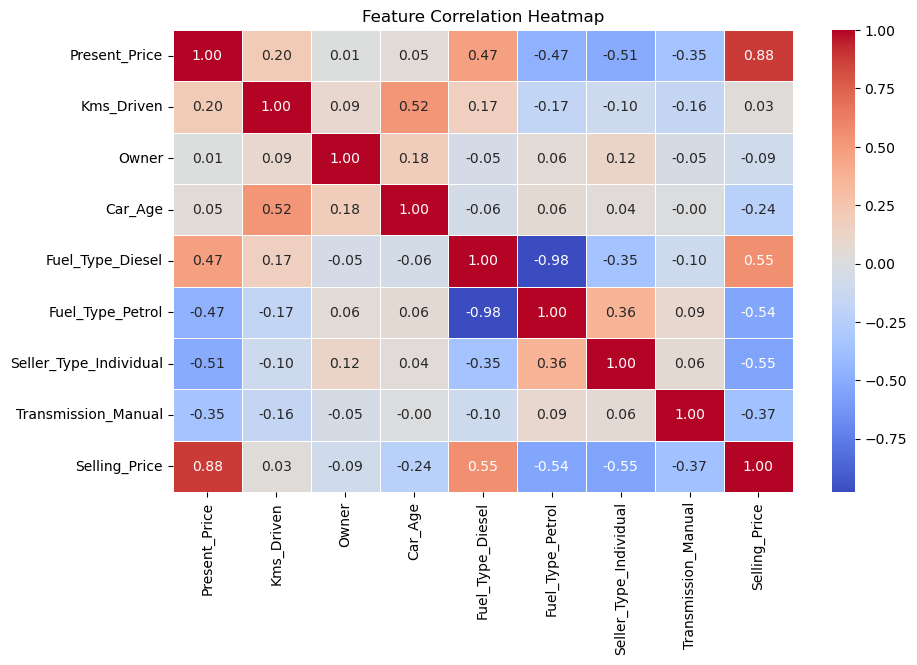

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(car_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

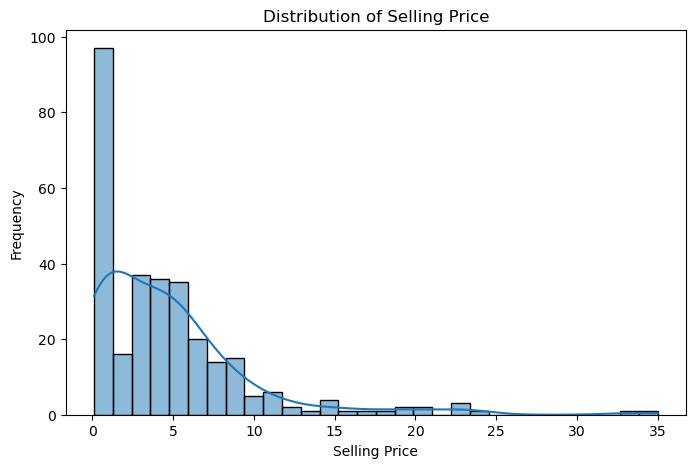

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(car_data["Selling_Price"], bins=30, kde=True)
plt.title("Distribution of Selling Price")
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.show()


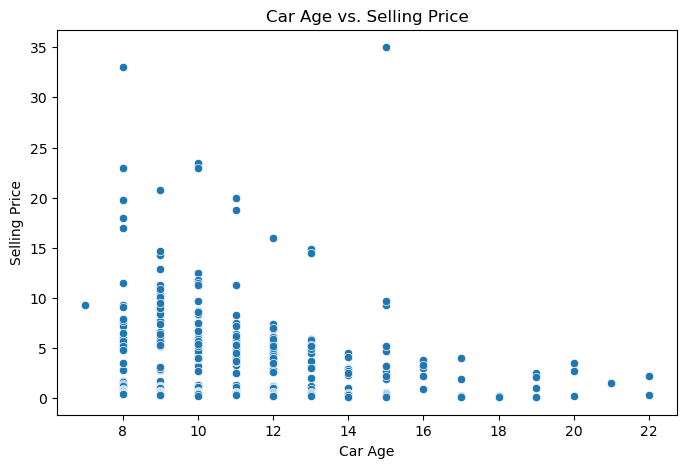

In [14]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=car_data["Car_Age"], y=car_data["Selling_Price"])
plt.title("Car Age vs. Selling Price")
plt.xlabel("Car Age")
plt.ylabel("Selling Price")
plt.show()

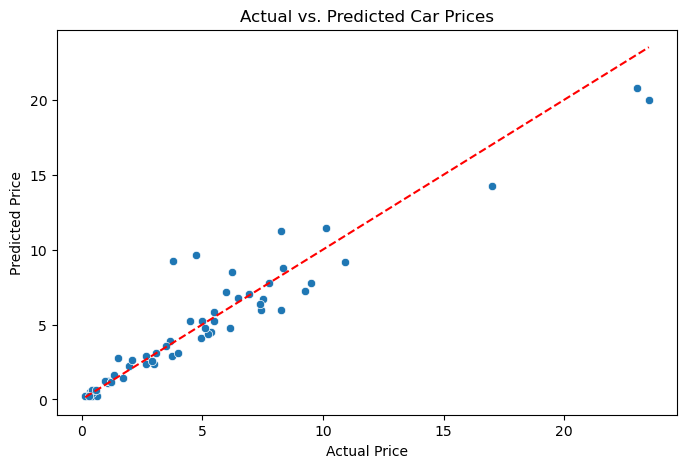

In [15]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Perfect fit line
plt.title("Actual vs. Predicted Car Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

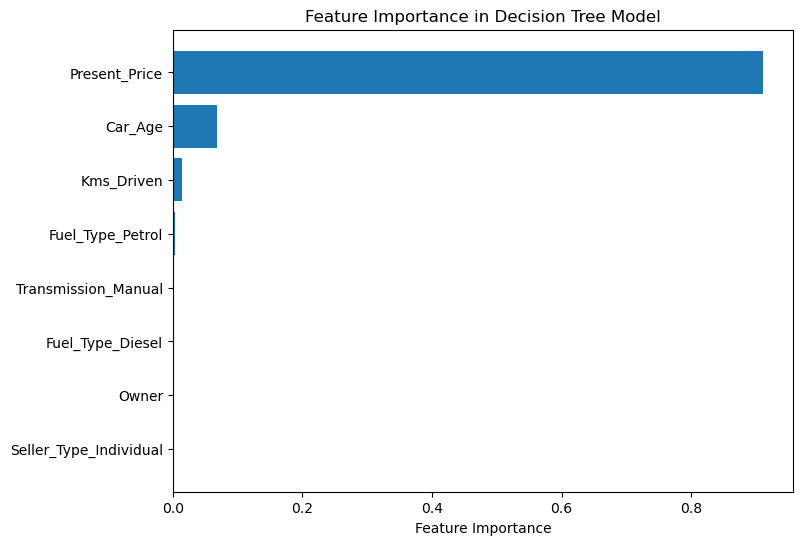

In [16]:
import numpy as np

# Get feature importance
feature_importance = grid_search.best_estimator_.feature_importances_
feature_names = X_train.columns

# Sort importance
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(8,6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Decision Tree Model")
plt.show()

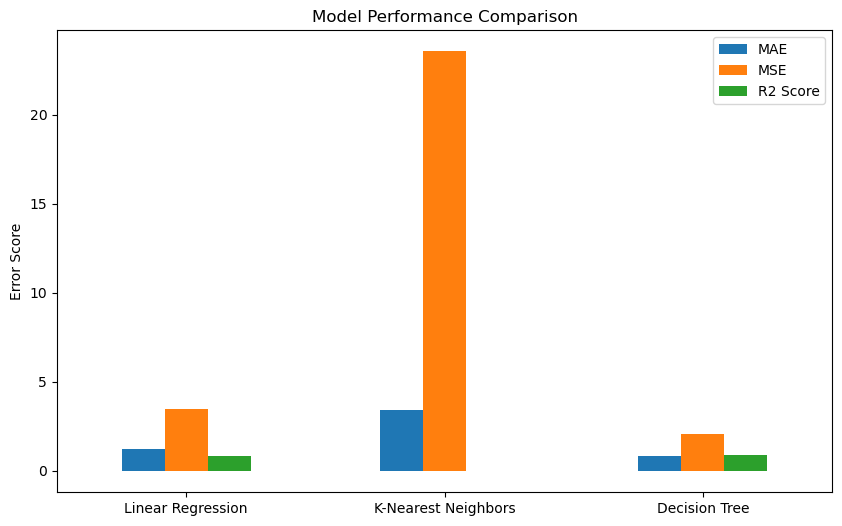

In [17]:
selected_performance_df.plot(kind='bar', figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Error Score")
plt.xticks(rotation=0)
plt.show()